# Imports
***

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from pylab import rcParams

%matplotlib inline
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 20,10
rcParams['font.size'] = 30
sns.set()
np.random.seed(8)

import scipy

# Loading and visualizing data
***

In [2]:
header_list = ["spec_name", "impl_name", "set_size", "edge_prob", "policy_size", "spec_len", "rego_lines_of_code", "error_rate", "edge_number", "comp_cum_time", "result"]
df = pd.read_csv("equivalence.dat", sep=';', usecols=[0,1,2,3,4,5,6,7,8,9,10], names=header_list)

chunks = pd.read_csv("equivalence.dat", sep=';', usecols=[0,1,2,3,4,5,6,7,8,9,10], names=header_list, chunksize=50000)
slim_data = []
for chunk in chunks:
    chunk["comp_cum_time"] *= 1000
    slim_data.append(chunk)
df = pd.concat(slim_data)

# Seconds to Milliseconds
#df["comp_cum_time"] *= 1000

df

,spec_name,impl_name,set_size,edge_prob,policy_size,spec_len,rego_lines_of_code,error_rate,edge_number,comp_cum_time,result
0,workflow-specs/randomly-generated/10-set-1-0-e...,impl-metagraph-generators/generated-from-rando...,10,1.0,1,24,332,0.0,35,0.188,True
1,workflow-specs/randomly-generated/10-set-1-0-e...,impl-metagraph-generators/generated-from-rando...,10,1.0,1,24,332,0.0,35,0.189,True
2,workflow-specs/randomly-generated/10-set-1-0-e...,impl-metagraph-generators/generated-from-rando...,10,1.0,1,24,332,0.0,35,0.283,True
3,workflow-specs/randomly-generated/10-set-1-0-e...,impl-metagraph-generators/generated-from-rando...,10,1.0,1,24,332,0.0,35,0.125,True
4,workflow-specs/randomly-generated/10-set-1-0-e...,impl-metagraph-generators/generated-from-rando...,10,1.0,1,24,332,0.0,35,0.117,True
...,...,...,...,...,...,...,...,...,...,...,...
1079995,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23781,0.7,614,7.668,False
1079996,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23781,0.7,614,8.697,False
1079997,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23781,0.7,614,8.238,False
1079998,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23781,0.7,614,61.615,False


# Removing outliers and harmonizing sample size
***

In [9]:
# All values of predictors
set_sizes = sorted(df.set_size.unique())
policy_sizes = sorted(df.policy_size.unique())
error_rates = sorted(df.error_rate.unique())


# Removing 0.7 error rates values from data
#error_rates = error_rates[:-1]


print("Used values:")
print("Set sizes: {}".format(set_sizes))
print("Policy sizes: {}".format(policy_sizes))
print("Error rates: {}".format(error_rates))
print("")


# Making list of DFs by predictors
preds_df_list = []
labels = []
for set_size in set_sizes:
    for policy_size in policy_sizes:
        for error_rate in error_rates:
            print("DF parameters: {} {} {}".format(set_size, policy_size, error_rate))
            labels.append("{} {} {}".format(set_size, policy_size, error_rate))
            preds_df_list.append(df[(df.set_size == set_size) & (df.policy_size == policy_size) & (df.error_rate == error_rate)])
print("\n")


print("Unmodified DF shapes")
for pred_df in preds_df_list:
    print(pred_df.shape)
print("\n")


# Removing outliers in DFs
new_preds_df_list = []
for pred_df in preds_df_list: # Remove all values with Z-score > 3
    new_preds_df_list.append( pred_df[np.abs(pred_df.comp_cum_time-pred_df.comp_cum_time.mean()) <= (3*pred_df.comp_cum_time.std())] )
preds_df_list = new_preds_df_list


# Print DF shapes to check sample sizes, put them in list
preds_df_list_sample_sizes = []
print("No outliers DF shapes")
for pred_df in preds_df_list:
    print(pred_df.shape)
    preds_df_list_sample_sizes.append(pred_df.shape[0])
print("\n")

minimum_sample_size = min(preds_df_list_sample_sizes)
print("Minimum common sample size: {}".format(minimum_sample_size))

# Make sample sizes equal
new_preds_df_list = []
for pred_df in preds_df_list:
    new_preds_df_list.append(pred_df.head(minimum_sample_size))
preds_df_list = new_preds_df_list


# Check new DF shapes
print("Modified DF shapes")
for pred_df in preds_df_list:
    print(pred_df.shape)
print("\n")

Used values:
Set sizes: [10, 20, 30, 50, 100]
Policy sizes: [1, 2]
Error rates: [0.0, 0.2, 0.4, 0.7]

DF parameters: 10 1 0.0
DF parameters: 10 1 0.2
DF parameters: 10 1 0.4
DF parameters: 10 1 0.7
DF parameters: 10 2 0.0
DF parameters: 10 2 0.2
DF parameters: 10 2 0.4
DF parameters: 10 2 0.7
DF parameters: 20 1 0.0
DF parameters: 20 1 0.2
DF parameters: 20 1 0.4
DF parameters: 20 1 0.7
DF parameters: 20 2 0.0
DF parameters: 20 2 0.2
DF parameters: 20 2 0.4
DF parameters: 20 2 0.7
DF parameters: 30 1 0.0
DF parameters: 30 1 0.2
DF parameters: 30 1 0.4
DF parameters: 30 1 0.7
DF parameters: 30 2 0.0
DF parameters: 30 2 0.2
DF parameters: 30 2 0.4
DF parameters: 30 2 0.7
DF parameters: 50 1 0.0
DF parameters: 50 1 0.2
DF parameters: 50 1 0.4
DF parameters: 50 1 0.7
DF parameters: 50 2 0.0
DF parameters: 50 2 0.2
DF parameters: 50 2 0.4
DF parameters: 50 2 0.7
DF parameters: 100 1 0.0
DF parameters: 100 1 0.2
DF parameters: 100 1 0.4
DF parameters: 100 1 0.7
DF parameters: 100 2 0.0
DF pa

# Merge all data back together
***

In [10]:
merged_df = pd.DataFrame()
for pred_df in preds_df_list:
    merged_df = merged_df.append(pred_df)

merged_df

,spec_name,impl_name,set_size,edge_prob,policy_size,spec_len,rego_lines_of_code,error_rate,edge_number,comp_cum_time,result
0,workflow-specs/randomly-generated/10-set-1-0-e...,impl-metagraph-generators/generated-from-rando...,10,1.0,1,24,332,0.0,35,0.188,True
1,workflow-specs/randomly-generated/10-set-1-0-e...,impl-metagraph-generators/generated-from-rando...,10,1.0,1,24,332,0.0,35,0.189,True
2,workflow-specs/randomly-generated/10-set-1-0-e...,impl-metagraph-generators/generated-from-rando...,10,1.0,1,24,332,0.0,35,0.283,True
3,workflow-specs/randomly-generated/10-set-1-0-e...,impl-metagraph-generators/generated-from-rando...,10,1.0,1,24,332,0.0,35,0.125,True
4,workflow-specs/randomly-generated/10-set-1-0-e...,impl-metagraph-generators/generated-from-rando...,10,1.0,1,24,332,0.0,35,0.117,True
...,...,...,...,...,...,...,...,...,...,...,...
1079868,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23781,0.7,614,7.475,False
1079869,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23781,0.7,614,7.324,False
1079870,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23781,0.7,614,7.225,False
1079871,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23781,0.7,614,8.134,False


# Fit m*log(m) curve to data
***

In [11]:
x = np.array(merged_df["edge_number"], dtype=float)
y = np.array(merged_df["comp_cum_time"], dtype=float)

def log_func(x, a, b):
    return a*x*np.log(x) + b
    
popt, pcov = scipy.optimize.curve_fit(log_func, x, y)
print("a = {}, b = {}".format(popt[0], popt[1]))
a_log = popt[0]
b_log = popt[1]

log_formula_str = merged_df.columns[-2] + ' ~ ' + 'log_func(edge_number, a_log, b_log)'
log_formula_str

a = 0.0024863014152139476, b = -0.1976008531846339


'comp_cum_time ~ log_func(edge_number, a_log, b_log)'

# Group data by edge number and calculate mean time
***

In [12]:
df_mod = merged_df.groupby('edge_number', as_index=False)['comp_cum_time'].mean()
df_mod

,edge_number,comp_cum_time
0,31,0.262104
1,33,0.271262
2,34,0.281256
3,35,0.276289
4,36,0.295382
...,...,...
142,643,8.993257
143,647,9.429017
144,649,11.726548
145,651,11.080661


# Scatter plot and regression
***
## All points
***

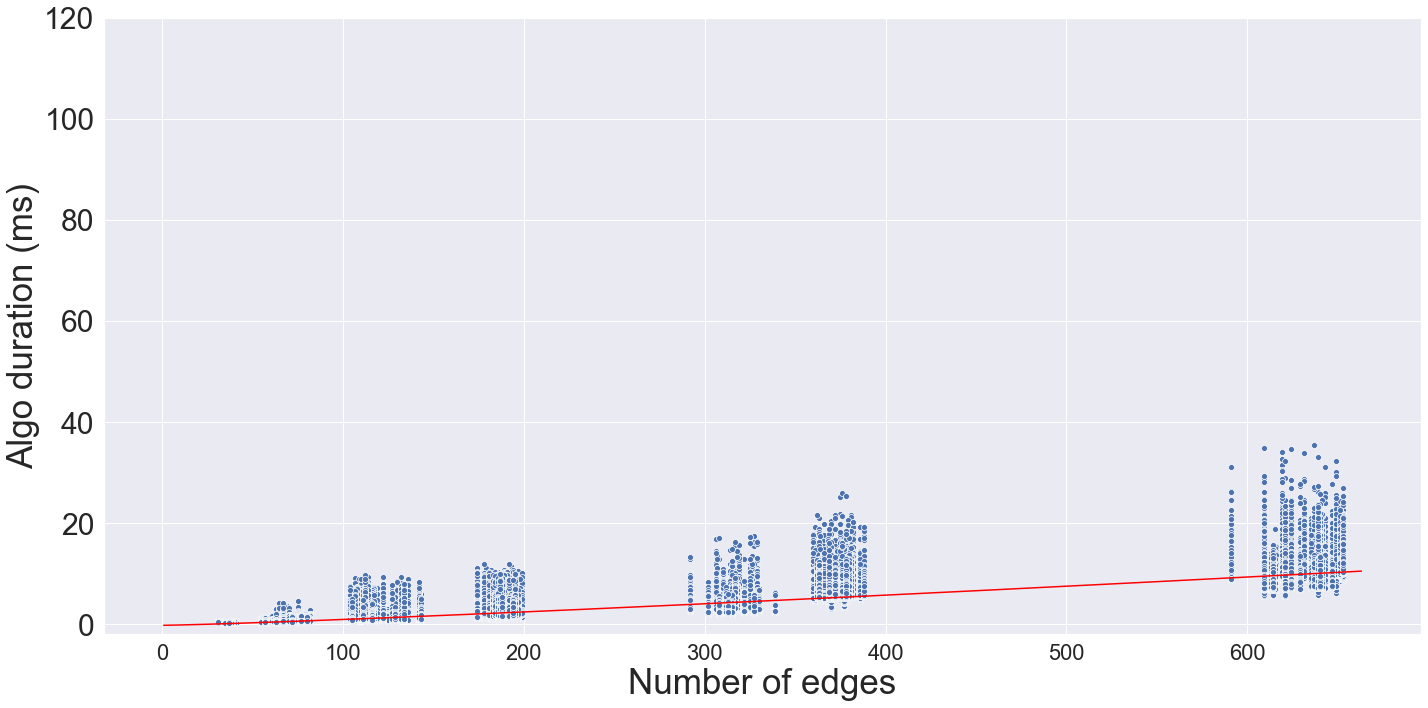

In [13]:
# Scatter plot
sns.scatterplot(data=merged_df, x="edge_number", y="comp_cum_time")

# Curve with fitted coefficients
x = np.linspace(1, merged_df["edge_number"].max() + 10, merged_df["edge_number"].max() + 10)
y = a_log * x * np.log(x) + b_log

# Plotting fitted curve on top of data
plt.plot(x, y, label="Fitted Curve", color="red")

plt.xticks(fontsize=22)
plt.yticks(fontsize=30)
plt.ylim(top=120)
plt.xlabel("Number of edges", fontsize=35)
plt.ylabel("Algo duration (ms)", fontsize=35)

plt.tight_layout()
plt.savefig("figures/scatterplot-regression.pdf")

## Only means
***

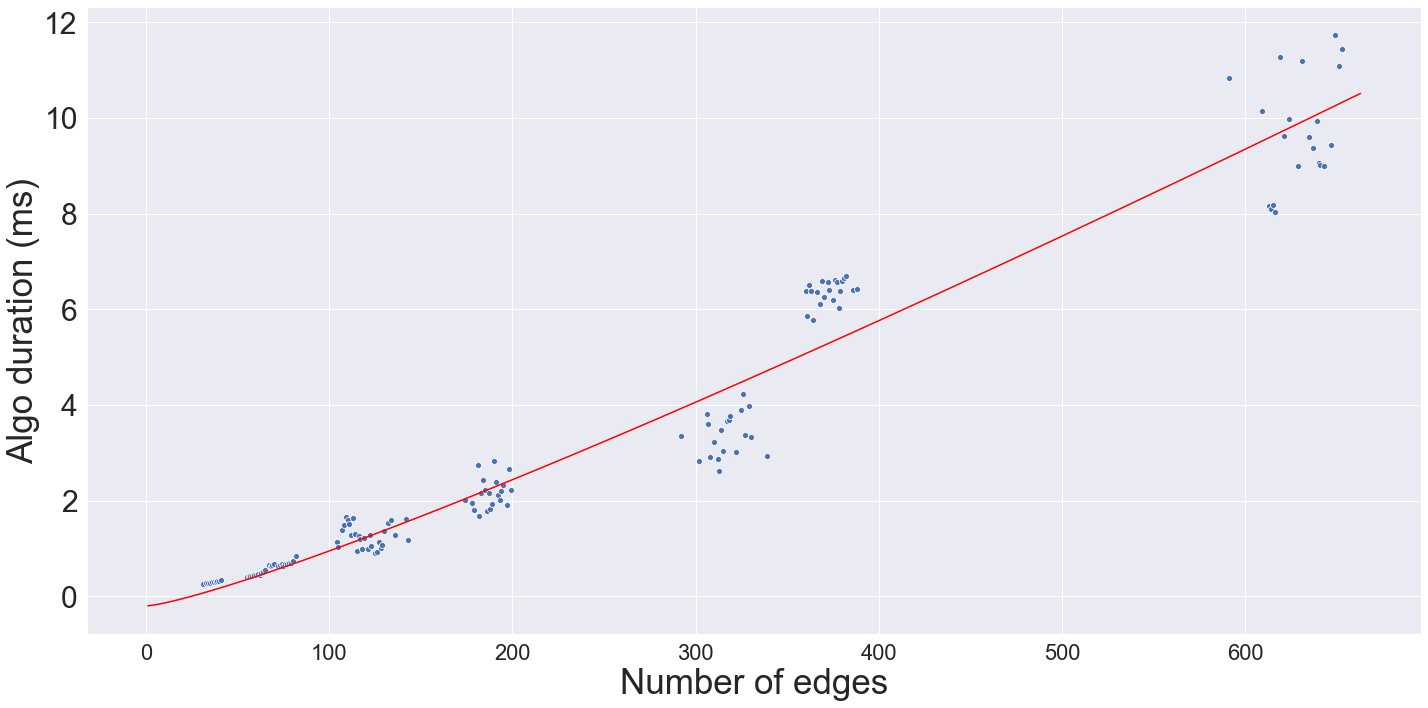

In [14]:
# Scatter plot
sns.scatterplot(data=df_mod, x="edge_number", y="comp_cum_time")

# Curve with fitted coefficients
x = np.linspace(1, merged_df["edge_number"].max() + 10, merged_df["edge_number"].max() + 10)
y = a_log * x * np.log(x) + b_log

# Plotting fitted curve on top of data
plt.plot(x, y, label="Fitted Curve", color="red")

plt.xticks(fontsize=22)
plt.yticks(fontsize=30)
plt.xlabel("Number of edges", fontsize=35)
plt.ylabel("Algo duration (ms)", fontsize=35)

plt.tight_layout()
plt.savefig("figures/scatterplot-means-regression.pdf")